<a href="https://colab.research.google.com/github/pritika-vig/MLHC-AgentBasedROI/blob/main/ML4H_Patch_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training (no need to run)

In [ ]:
### Below is the code for the model's training. It was run on a local machine.

"""

import h5py
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Step 1: Load metadata and splits
def load_metadata(path):
    return pd.read_csv(path)

train_meta = load_metadata("/lotterlab/users/abdallah/ML4H/data/pcamv1/camelyonpatch_level_2_split_train_meta.csv")
valid_meta = load_metadata("/lotterlab/users/abdallah/ML4H/data/pcamv1/camelyonpatch_level_2_split_valid_meta.csv")
patient_splits = load_metadata("/lotterlab/users/abdallah/ML4H/data/pcamv1/final_split.csv")

# Step 2: Load data from h5 files (train and val only)
def load_h5_data(x_path, y_path):
    with h5py.File(x_path, 'r') as fx, h5py.File(y_path, 'r') as fy:
        x = np.array(fx['x'])
        y = np.array(fy['y'])
    return x, y

print("Loading train data...")
train_x, train_y = load_h5_data(
    "/lotterlab/users/abdallah/ML4H/data/pcamv1/camelyonpatch_level_2_split_train_x.h5",
    "/lotterlab/users/abdallah/ML4H/data/pcamv1/camelyonpatch_level_2_split_train_y.h5")

print("Loading validation data...")
val_x, val_y = load_h5_data(
    "/lotterlab/users/abdallah/ML4H/data/pcamv1/camelyonpatch_level_2_split_valid_x.h5",
    "/lotterlab/users/abdallah/ML4H/data/pcamv1/camelyonpatch_level_2_split_valid_y.h5")

# Step 3: Combine train and validation sets
all_x = np.concatenate([train_x, val_x], axis=0)
all_y = np.concatenate([train_y, val_y], axis=0)
all_meta = pd.concat([train_meta, valid_meta], axis=0).reset_index(drop=True)

# Verify they have the same number of samples
print(f"Combined data: {all_x.shape[0]} images, {all_y.shape[0]} labels, {len(all_meta)} metadata rows")

# Step 4: Create a map between WSI and patient IDs
# Extract patient_id from WSI ID in metadata (camelyon16_train_tumor_073 -> tumor_073)
def extract_patient_id(wsi):
    """Extract patient ID from WSI string"""
    parts = wsi.split('_')
    if 'tumor' in parts:
        tumor_idx = parts.index('tumor')
        return f"tumor_{parts[tumor_idx + 1]}"
    elif 'normal' in parts:
        normal_idx = parts.index('normal')
        return f"normal_{parts[normal_idx + 1]}"
    else:
        # Handle test WSIs which might have a different format
        if 'test' in parts:
            return wsi  # Just use the full ID for test WSIs
    return None

# Add patient_id column to the metadata
all_meta['patient_id'] = all_meta['wsi'].apply(extract_patient_id)

# Step 5: Create sets of patient IDs for each split
train_patients = set(patient_splits[patient_splits['split'] == 'train']['patient_id'])
val_patients = set()
test_patients = set()

# ✅ Toggle this ON to debug quickly on a small dataset
test_mode = False  # 🚨 Set to False to run full training on all patients

if test_mode:
    print("⚠️ Running in TEST MODE on 10 patients (5 tumor, 5 normal)")

    # Filter only patients with at least one patch
    labeled_meta = all_meta.copy()
    labeled_meta['label'] = all_y.flatten()  # all_y is aligned with all_meta rows

    # Identify patients with tumor and normal labels
    tumor_patient_ids = labeled_meta[labeled_meta['label'] == 1]['patient_id'].unique()
    normal_patient_ids = labeled_meta[labeled_meta['label'] == 0]['patient_id'].unique()

    # Pick 5 tumor + 5 normal patients
    selected_tumor = sorted(tumor_patient_ids)[:5]
    selected_normal = sorted(normal_patient_ids)[:5]
    selected_patients = list(selected_tumor) + list(selected_normal)

    # Optionally shuffle
    np.random.shuffle(selected_patients)

    # Assign 6 to train, 2 to val, 2 to test
    train_patients = set(selected_patients[:6])
    val_patients   = set(selected_patients[6:8])
    test_patients  = set(selected_patients[8:10])

    print(f"Train patients: {train_patients}")
    print(f"Validation patients: {val_patients}")
    print(f"Test patients: {test_patients}")

# If not in test mode, use the full patient_splits
else:
    # Check if the patient_splits dataframe has the expected columns
    if 'split' not in patient_splits.columns or 'patient_id' not in patient_splits.columns:
        raise ValueError("patient_splits dataframe must contain 'split' and 'patient_id' columns")

    # Get unique patients for each split
    train_patients = set(patient_splits[patient_splits['split'] == 'train']['patient_id'])
    val_patients = set(patient_splits[patient_splits['split'] == 'val']['patient_id'])
    test_patients = set(patient_splits[patient_splits['split'] == 'test']['patient_id'])
    print(f"Train patients: {len(train_patients)}")
    print(f"Validation patients: {len(val_patients)}")
    print(f"Test patients: {len(test_patients)}")


print(f"Train patients: {len(train_patients)}")
print(f"Validation patients: {len(val_patients)}")
print(f"Test patients: {len(test_patients)}")

# Step 6: Create indices for each split based on patient IDs
train_indices = all_meta[all_meta['patient_id'].isin(train_patients)].index.tolist()
val_indices = all_meta[all_meta['patient_id'].isin(val_patients)].index.tolist()
test_indices = all_meta[all_meta['patient_id'].isin(test_patients)].index.tolist()

print(f"Train samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"Test samples: {len(test_indices)}")

# Step 7: Balance datasets by having equal number of tumor/normal patches
def balance_dataset(indices, labels, meta_df):
    """Create a balanced dataset with equal normal/tumor patches"""
    # Get indices for tumor and normal patches
    tumor_indices = [i for i in indices if labels[i] == 1]
    normal_indices = [i for i in indices if labels[i] == 0]

    # Calculate how many samples to use (use all tumor samples, sample same number of normal)
    n_tumor = len(tumor_indices)
    n_normal = min(len(normal_indices), n_tumor)  # Use at most n_tumor normal samples
    print(f"  Tumor samples: {n_tumor}, Normal samples: {len(normal_indices)}")
    print(f"  Sampling {n_normal} normal samples to balance with {n_tumor} tumor samples")

    # If less tumor than normal, use all tumor and sample normal
    if n_tumor <= len(normal_indices):
        sampled_normal = np.random.choice(normal_indices, size=n_tumor, replace=False)
        balanced_indices = tumor_indices + sampled_normal.tolist()
    # If more tumor than normal, use all normal and sample tumor
    else:
        sampled_tumor = np.random.choice(tumor_indices, size=n_normal, replace=False)
        balanced_indices = sampled_tumor.tolist() + normal_indices

    np.random.shuffle(balanced_indices)  # Shuffle the combined list

    # Calculate statistics for the balanced dataset
    tumor_count = sum(1 for i in balanced_indices if labels[i] == 1)
    normal_count = sum(1 for i in balanced_indices if labels[i] == 0)

    print(f"  Balanced dataset: {len(balanced_indices)} total samples")
    print(f"  Tumor samples: {tumor_count}, Normal samples: {normal_count}")

    # List the number of samples per patient
    patient_counts = defaultdict(int)
    for i in balanced_indices:
        patient_id = meta_df.loc[i, 'patient_id']
        patient_counts[patient_id] += 1

    print(f"  Samples from {len(patient_counts)} unique patients")

    return balanced_indices

# Balance each split
print("\nBalancing train set:")
balanced_train_indices = balance_dataset(train_indices, all_y, all_meta)

print("\nBalancing validation set:")
balanced_val_indices = balance_dataset(val_indices, all_y, all_meta)

print("\nBalancing test set:")
balanced_test_indices = balance_dataset(test_indices, all_y, all_meta)

# Step 8: Create the final balanced datasets
train_x_balanced = all_x[balanced_train_indices]
train_y_balanced = all_y[balanced_train_indices]
train_meta_balanced = all_meta.iloc[balanced_train_indices].reset_index(drop=True)

val_x_balanced = all_x[balanced_val_indices]
val_y_balanced = all_y[balanced_val_indices]
val_meta_balanced = all_meta.iloc[balanced_val_indices].reset_index(drop=True)

test_x_balanced = all_x[balanced_test_indices]
test_y_balanced = all_y[balanced_test_indices]
test_meta_balanced = all_meta.iloc[balanced_test_indices].reset_index(drop=True)

print("\nFinal dataset sizes:")
print(f"Train: {train_x_balanced.shape[0]} samples")
print(f"Validation: {val_x_balanced.shape[0]} samples")
print(f"Test: {test_x_balanced.shape[0]} samples")


from torch.utils.data import Dataset

class OnTheFlyDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x = x_data  # still in uint8
        self.y = y_data
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        img = self.x[index]  # shape (96, 96, 3), dtype uint8
        label = int(self.y[index].item())  # ✅ safely converts scalar array to Python int

        # Preprocess only this image
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # (C, H, W)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

train_dataset = OnTheFlyDataset(train_x_balanced, train_y_balanced)
val_dataset   = OnTheFlyDataset(val_x_balanced, val_y_balanced)
test_dataset  = OnTheFlyDataset(test_x_balanced, test_y_balanced)


# Step 11: Create datasets and dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

# Save the patient-level split and balanced datasets
save_dir = "/lotterlab/users/abdallah/ML4H/data/pcamv1/patient_splits/"
os.makedirs(save_dir, exist_ok=True)



import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
import time

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import os
import datetime

# Create timestamped directory for this run
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = f"/lotterlab/users/abdallah/ML4H/results/run_{timestamp}"
os.makedirs(run_dir, exist_ok=True)
print(f"Created results directory: {run_dir}")

# Update the file paths to use the new directory
def get_run_path(filename):
    return os.path.join(run_dir, filename)


# Model
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        # Load pre-trained ResNet50
        base_model = models.resnet50(weights='IMAGENET1K_V1')

        # Extract all layers except the final classifier
        layers = list(base_model.children())[:-1]
        self.features = nn.Sequential(*layers)

        # Freeze only the early layers (first 6 blocks)
        ct = 0
        for child in self.features.children():
            ct += 1
            if ct < 7:  # Freeze early layers
                for param in child.parameters():
                    param.requires_grad = False

        # Add custom classifier with more capacity
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model
model = ResNetModel()
model = model.to(device)
# Print model summary
print(model)

# Count total and trainable parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

count_parameters(model)

# Define loss function and optimizer
# Define customized loss function with positive class emphasis
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=1.5):  # Increase this value to emphasize positive predictions
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, outputs, targets):
        # Standard BCE loss calculation
        bce_loss = nn.BCELoss(reduction='none')(outputs, targets)

        # Apply weights: increase loss for positive examples
        weights = torch.ones_like(targets)
        weights[targets > 0] = self.pos_weight  # Higher weight for positive class

        # Return weighted loss
        return (weights * bce_loss).mean()

# Use this loss function instead of standard BCE
criterion = WeightedBCELoss(pos_weight=1.5)

optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=30, patience=5):
    best_val_auc = 0.0
    patience_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_aucs = []
    val_aucs = []
    best_model_weights = None

    start_time = time.time()

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.detach().cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Calculate AUC
        fpr, tpr, _ = roc_curve(np.array(all_targets), np.array(all_predictions))
        epoch_auc = auc(fpr, tpr)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_aucs.append(epoch_auc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device).float().unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                all_targets.extend(targets.cpu().numpy())
                all_predictions.extend(outputs.cpu().numpy())

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = correct / total

        # Calculate AUC
        fpr, tpr, _ = roc_curve(np.array(all_targets), np.array(all_predictions))
        val_epoch_auc = auc(fpr, tpr)

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)
        val_aucs.append(val_epoch_auc)

        # Update learning rate
        scheduler.step(val_epoch_loss)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f} - AUC: {epoch_auc:.4f} - "
              f"Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f} - Val AUC: {val_epoch_auc:.4f}")

        # Check early stopping
        if val_epoch_auc > best_val_auc:
            best_val_auc = val_epoch_auc
            patience_counter = 0
            best_model_weights = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Load best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)

    history = {
        'loss': train_losses,
        'accuracy': train_accuracies,
        'auc': train_aucs,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
        'val_auc': val_aucs
    }

    return model, history

# Train the model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

# Save the model
model_save_path = get_run_path("saved_resnet_model.pt")
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, model_save_path)
print(f"Model saved to: {model_save_path}")

# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(history['auc'], label='Train AUC')
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.savefig(get_run_path("training_history.png"))
plt.close()


# Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total

    # Calculate AUC
    fpr, tpr, _ = roc_curve(np.array(all_targets), np.array(all_predictions))
    test_auc = auc(fpr, tpr)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    return test_loss, test_acc, test_auc, all_targets, all_predictions

test_loss, test_acc, test_auc, y_true, y_pred_proba = evaluate_model(model, test_loader)

# Convert predictions to binary
y_pred = (np.array(y_pred_proba) > 0.5).astype(int)

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig(get_run_path("roc_curve.png"))
plt.close()

# Show some example predictions
def plot_predictions(images, true_labels, predictions, n=10):
    # Convert from PyTorch format (B, C, H, W) to display format (B, H, W, C)
    images = images.transpose(0, 2, 3, 1)

    plt.figure(figsize=(20, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}")
        plt.axis('off')

        plt.subplot(2, n, i+n+1)
        plt.imshow(images[i])
        plt.title(f"Pred: {predictions[i][0]:.2f}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(get_run_path("example_predictions.png"))
    plt.close()

# Get a batch of test images and their predictions
test_batch = next(iter(test_loader))
test_images = test_batch[0].cpu().numpy()
test_labels = test_batch[1].cpu().numpy()
with torch.no_grad():
    inputs = test_batch[0].to(device)
    test_preds = model(inputs).cpu().numpy()

# Plot the test images with their true and predicted labels
plot_predictions(test_images, test_labels, test_preds)


"""

# Model loading (🚨 **Note:** you have to add the shared "Dataset" folder as a short cut in your "MyDrive" folder 🚨)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


🚨 **Note:** you have to add the shared "Dataset" folder as a short cut in your "MyDrive" folder 🚨

In [ ]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report

In [ ]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        # Load pre-trained ResNet50
        base_model = models.resnet50(weights='IMAGENET1K_V1')

        # Extract all layers except the final classifier
        layers = list(base_model.children())[:-1]
        self.features = nn.Sequential(*layers)

        # Freeze only the early layers (first 6 blocks)
        ct = 0
        for child in self.features.children():
            ct += 1
            if ct < 7:  # Freeze early layers
                for param in child.parameters():
                    param.requires_grad = False

        # Add custom classifier with more capacity
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Reload the trained model
def load_model_from_checkpoint(path):
    checkpoint = torch.load(path, weights_only=False) # Set weights_only to False
    model = ResNetModel()
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model

# Try loading the weights-only format (most likely to work)
model = ResNetModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/Dataset/model_weights_only.pt', map_location='cpu'))
model.eval()
print("Model loaded successfully using weights-only format")

Using device: cpu


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


Model loaded successfully using weights-only format


In [ ]:
def load_h5_data(x_path, y_path):
    with h5py.File(x_path, 'r') as fx, h5py.File(y_path, 'r') as fy:
        x = np.array(fx['x'])
        y = np.array(fy['y'])
    return x, y

print("Loading test dataset...")
test_x_path = "/content/drive/MyDrive/Dataset/pcamv1/camelyonpatch_level_2_split_test_x.h5"
test_y_path = "/content/drive/MyDrive/Dataset/pcamv1/camelyonpatch_level_2_split_test_y.h5"
test_x, test_y = load_h5_data(test_x_path, test_y_path)
print(f"Test data loaded. Shape: {test_x.shape}, Labels shape: {test_y.shape}")

# Preprocess
def preprocess_np(x, y):
    x = x.astype(np.float32) / 255.0  # Normalize to [0,1]
    x = x.transpose(0, 3, 1, 2)  # Convert to (B, C, H, W)
    y = y.astype(np.int64).reshape(-1)  # Flatten labels
    return x, y

# Process all data (or subset for faster execution)
SAMPLE_SIZE = 100  # Use a subset for quick testing
sampled_indices = np.random.choice(len(test_x), min(SAMPLE_SIZE, len(test_x)), replace=False)
test_x_sample = test_x[sampled_indices]
test_y_sample = test_y[sampled_indices]

# Preprocess
processed_x, processed_y = preprocess_np(test_x_sample, test_y_sample)

# Create DataLoader
BATCH_SIZE = 32
test_dataset = TensorDataset(torch.from_numpy(processed_x), torch.from_numpy(processed_y))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. Run predictions
criterion = nn.BCELoss()

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total

    # Calculate AUC
    fpr, tpr, _ = roc_curve(np.array(all_targets), np.array(all_predictions))
    test_auc = auc(fpr, tpr)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    return test_loss, test_acc, test_auc, all_targets, all_predictions

print("Evaluating model on test data...")
test_loss, test_acc, test_auc, y_true, y_pred_proba = evaluate_model(model, test_loader)

# Convert predictions to binary
y_pred = (np.array(y_pred_proba) > 0.5).astype(int)

Loading test dataset...
Test data loaded. Shape: (32768, 96, 96, 3), Labels shape: (32768, 1, 1, 1)
Evaluating model on test data...
Test Loss: 0.9102
Test Accuracy: 0.8300
Test AUC: 0.9175


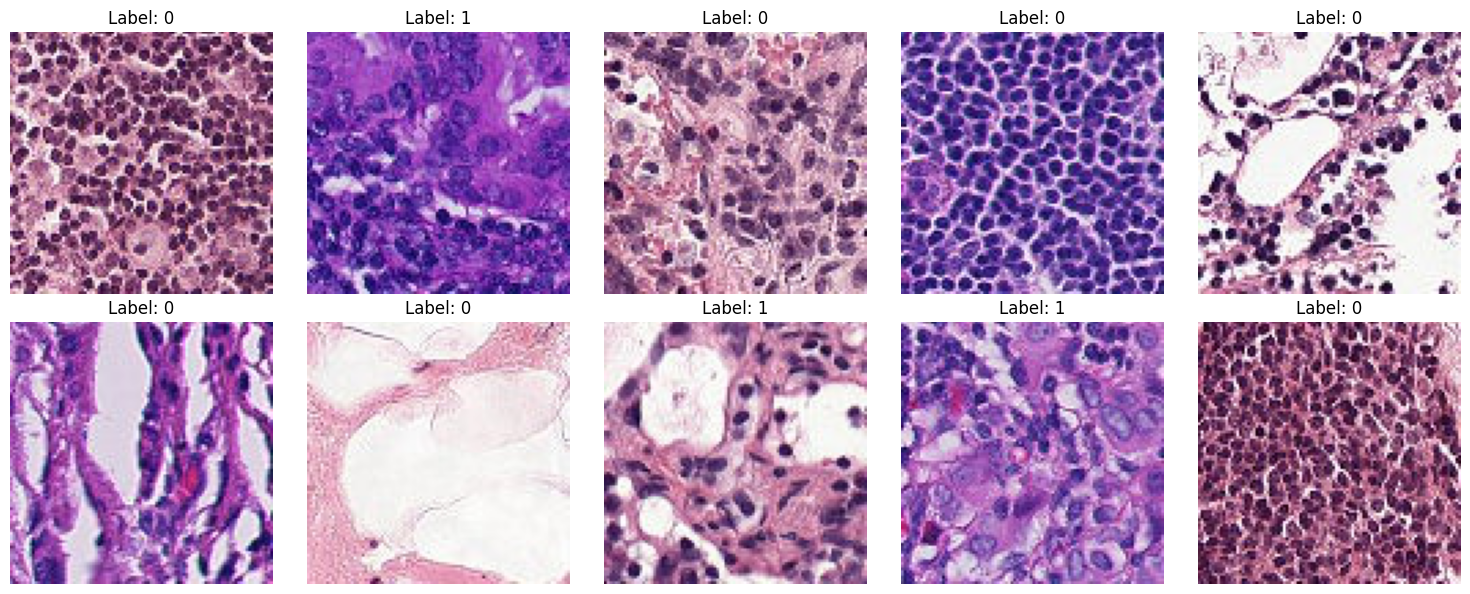

Stats des images prétraitées:
Format: torch.Size([10, 3, 96, 96])
Min: 0.0, Max: 1.0, Moyenne: 0.6001543998718262


In [ ]:
# Affichage de quelques images après prétraitement
def display_preprocessed_images(dataloader, num_images=10):
    # Obtenir un batch
    images, labels = next(iter(dataloader))

    # Limiter au nombre d'images demandé
    images = images[:num_images]
    labels = labels[:num_images]

    # Convertir de (C, H, W) à (H, W, C) pour l'affichage
    images_display = images.numpy().transpose(0, 2, 3, 1)

    # Afficher les images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, (img, label) in enumerate(zip(images_display, labels)):
        # Les images sont normalisées entre 0 et 1
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label.item()}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print("Stats des images prétraitées:")
    print(f"Format: {images.shape}")
    print(f"Min: {images.min().item()}, Max: {images.max().item()}, Moyenne: {images.mean().item()}")

# Afficher les 10 premiers patchs prétraités
display_preprocessed_images(test_loader, num_images=10)


Sample predictions (green = correct, red = incorrect):


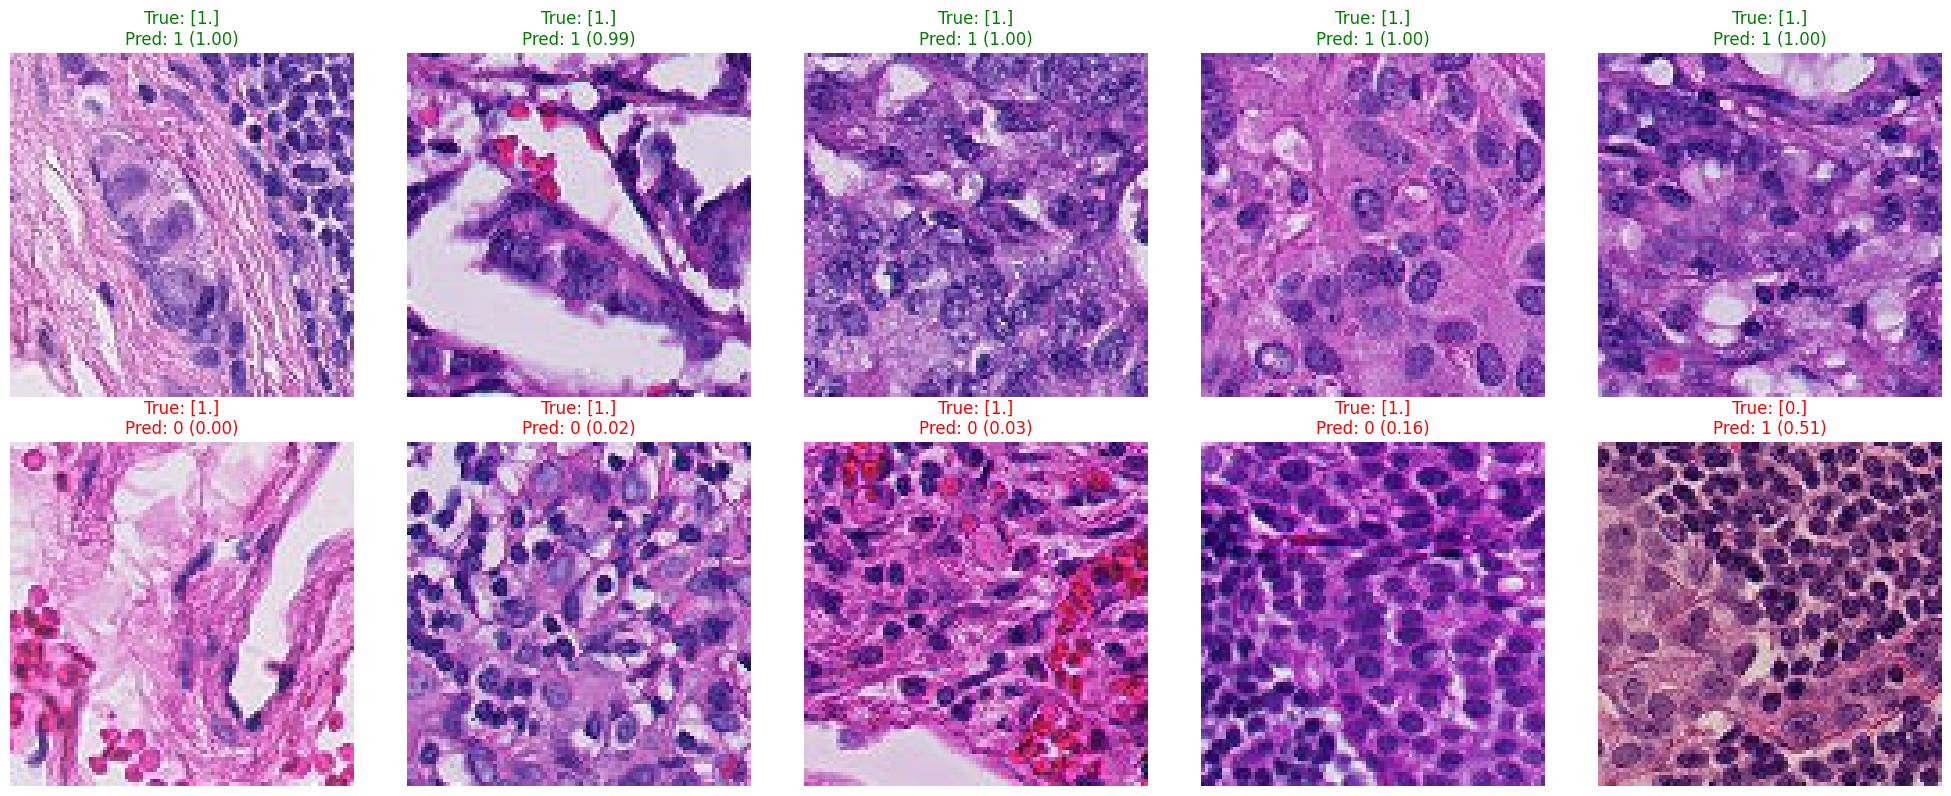

In [ ]:
def plot_predictions(images, true_labels, pred_probs, n=10):
    plt.figure(figsize=(20, 8))

    # Convert back from PyTorch format (B, C, H, W) to display format (B, H, W, C)
    img_display = test_x_sample[:n]

    for i in range(n):
        plt.subplot(2, 5, i+1)
        plt.imshow(img_display[i])
        true_label = true_labels[i]
        pred_prob = pred_probs[i][0]
        pred_label = 1 if pred_prob > 0.5 else 0

        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})",
                 color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get indices for visualizing both correct and incorrect predictions
correct_idx = [i for i in range(len(y_true)) if y_pred[i] == y_true[i]]
incorrect_idx = [i for i in range(len(y_true)) if y_pred[i] != y_true[i]]

# Sample from correct and incorrect for balanced view
sample_idx = (correct_idx[:5] if len(correct_idx) >= 5 else correct_idx) + \
             (incorrect_idx[:5] if len(incorrect_idx) >= 5 else incorrect_idx)

if len(sample_idx) > 0:
    print("\nSample predictions (green = correct, red = incorrect):")
    sample_images = [test_x_sample[i] for i in sample_idx]
    sample_true = [y_true[i] for i in sample_idx]
    sample_preds = [y_pred_proba[i] for i in sample_idx]
    plot_predictions(sample_images, sample_true, sample_preds, n=len(sample_idx))
else:
    print("No samples to display")